In [18]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
import warnings
warnings.filterwarnings("ignore")

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['label_1','label_3','label_4','label_5','label_6','label_7','label_8']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [21]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]    [16, 7]              768                  Partial
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]    [16, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [16, 197, 768]       [16, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [16, 197, 768]       [16, 197, 768]       --                   --
│    └─Sequential (layers)                                   [16, 197, 768]       [16, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 768]       [16, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 768]       [16, 

In [22]:
# Setup directory paths to train and test images
train_dir = 'seperated_heatmap_data/train'
test_dir = 'seperated_heatmap_data/test'

In [23]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [24]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [25]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=16) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [26]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [04:08<37:20, 248.93s/it]

Epoch: 1 | train_loss: 0.2602 | train_acc: 0.9246 | test_loss: 0.2018 | test_acc: 0.9369


 20%|██        | 2/10 [08:18<33:12, 249.05s/it]

Epoch: 2 | train_loss: 0.1731 | train_acc: 0.9455 | test_loss: 0.1689 | test_acc: 0.9434


 30%|███       | 3/10 [12:29<29:10, 250.04s/it]

Epoch: 3 | train_loss: 0.1569 | train_acc: 0.9486 | test_loss: 0.1744 | test_acc: 0.9384


 40%|████      | 4/10 [16:41<25:04, 250.82s/it]

Epoch: 4 | train_loss: 0.1484 | train_acc: 0.9498 | test_loss: 0.1760 | test_acc: 0.9384


 50%|█████     | 5/10 [21:07<21:21, 256.26s/it]

Epoch: 5 | train_loss: 0.1377 | train_acc: 0.9525 | test_loss: 0.1481 | test_acc: 0.9498


 60%|██████    | 6/10 [25:25<17:07, 256.91s/it]

Epoch: 6 | train_loss: 0.1356 | train_acc: 0.9534 | test_loss: 0.1417 | test_acc: 0.9522


 70%|███████   | 7/10 [29:42<12:51, 257.04s/it]

Epoch: 7 | train_loss: 0.1265 | train_acc: 0.9560 | test_loss: 0.1564 | test_acc: 0.9487


 80%|████████  | 8/10 [33:59<08:34, 257.11s/it]

Epoch: 8 | train_loss: 0.1256 | train_acc: 0.9558 | test_loss: 0.1530 | test_acc: 0.9504


 90%|█████████ | 9/10 [38:17<04:17, 257.27s/it]

Epoch: 9 | train_loss: 0.1214 | train_acc: 0.9583 | test_loss: 0.1366 | test_acc: 0.9513


100%|██████████| 10/10 [42:33<00:00, 255.40s/it]

Epoch: 10 | train_loss: 0.1176 | train_acc: 0.9593 | test_loss: 0.1760 | test_acc: 0.9478


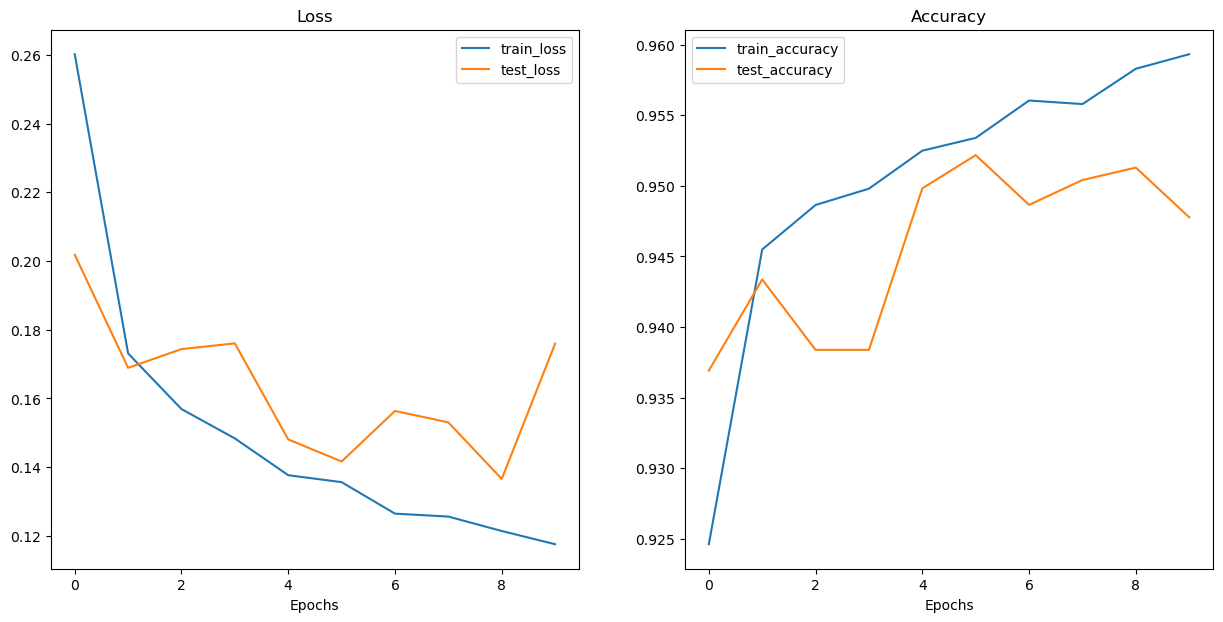

In [27]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

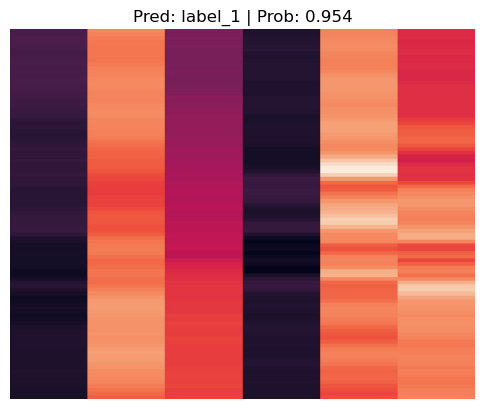

In [32]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "501_heatmap_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)